# Capstone Two - 4 Pre-Processing and ARIMA Model<a id='4'></a>

## 4.1 Contents<a id='4.1'></a>
* [4 Pre-Processing and Training Data](#4)
  * [4.1 Contents](#4.1)
  * [4.2 Imports](#4.2)
  * [4.3 Load The Data](#4.3)
  * [4.4 Processing Categorical Variables](#4.4)
  * [4.5 Time Series Components](#4.5)
    * [4.5.1 Stationarity testing](#4.5.1)
    * [4.5.2 Determine Order of Differencing](#4.5.2)
    * [4.5.3 Identify Order of AR and MA Terms](#4.5.3) 
  * [4.6 Fit ARIMA Model](#4.6)  
  * [4.7 Save data](#4.5)
  * [4.8 Summary](#4.6)

## 4.2 Imports<a id='4.2'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error

from library.sb_utils import save_file

## 4.3 Load The Data<a id='4.3'></a>

In [2]:
data_dir = '../data/'

# Grocery sales at store No.44
data = pd.read_csv(data_dir+'train_selected_group.csv')

In [3]:
data.head(8)

,date,sales,onpromotion,dcoilwtico,transactions,holiday_type,transferred,day_of_week,sales_lag1,sales_lag2,sales_lag3,sales_3_day_avg,sales_week_avg
0,2013-01-01,0.0,0.0,93.14,0.0,Holiday,False,Tuesday,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,10686.0,0.0,93.14,4821.0,Normal,False,Wednesday,0.0,NaN,NaN,NaN,NaN
2,2013-01-03,7342.0,0.0,92.97,3618.0,Normal,False,Thursday,10686.0,0.0,NaN,NaN,NaN
3,2013-01-04,7250.0,0.0,93.12,4169.0,Normal,False,Friday,7342.0,10686.0,0.0,6009.3,NaN
4,2013-01-05,10699.0,0.0,93.12,4921.0,Work Day,False,Saturday,7250.0,7342.0,10686.0,8426.0,NaN
5,2013-01-06,12373.0,0.0,93.12,4925.0,Normal,False,Sunday,10699.0,7250.0,7342.0,8430.3,NaN
6,2013-01-07,7059.0,0.0,93.20,3871.0,Normal,False,Monday,12373.0,10699.0,7250.0,10107.3,NaN
7,2013-01-08,19849.0,0.0,93.21,3593.0,Normal,False,Tuesday,7059.0,12373.0,10699.0,10043.7,7915.6


Note that on the first date "2013-01-01", the store was colsed so the sales was zero. And the first 7 rows of the "lag" columns were NaN.

## 4.4 Processing Categorical Features<a id='4.4'></a>

Create dummy or indicator features for categorical variables: day_of_week and holiday.

In [4]:
# Weekday or Weekend
data.loc[data['day_of_week'].isin(['Monday','Tuesday','Wednesday','Thursday','Friday']), 'day_of_week'] = 'Weekday'
data.loc[data['day_of_week'].isin(['Saturday','Sunday']), 'day_of_week'] = 'Weekend'

In [5]:
# Weekend but Workday -> Weekday
data.loc[data['holiday_type'] == 'Work Day', 'day_of_week'] = 'Weekday'

In [6]:
# Holiday or Non_holiday
data.loc[ (data['holiday_type'] == 'Holiday') & (data['transferred'] == True), 'holiday_type'] = 'Non_holiday'
data.loc[ data['holiday_type'].isin(['Additional','Bridge','Event','Transfer']), 'holiday_type'] = 'Holiday'
data.loc[ data['holiday_type'].isin(['Normal','Work Day']), 'holiday_type'] = 'Non_holiday'

In [7]:
dummy_hol = pd.get_dummies(data['holiday_type'])
dummy_hol.head()

,Holiday,Non_holiday
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1


In [8]:
dummy_dow = pd.get_dummies(data['day_of_week'])
dummy_dow.head()

,Weekday,Weekend
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [9]:
data = pd.concat([data, dummy_hol], axis=1)
data = pd.concat([data, dummy_dow], axis=1)

In [10]:
data.drop(['holiday_type', 'transferred', 'day_of_week'], axis=1, inplace=True)

In [11]:
data.head()

,date,sales,onpromotion,dcoilwtico,transactions,sales_lag1,sales_lag2,sales_lag3,sales_3_day_avg,sales_week_avg,Holiday,Non_holiday,Weekday,Weekend
0,2013-01-01,0.0,0.0,93.14,0.0,NaN,NaN,NaN,NaN,NaN,1,0,1,0
1,2013-01-02,10686.0,0.0,93.14,4821.0,0.0,NaN,NaN,NaN,NaN,0,1,1,0
2,2013-01-03,7342.0,0.0,92.97,3618.0,10686.0,0.0,NaN,NaN,NaN,0,1,1,0
3,2013-01-04,7250.0,0.0,93.12,4169.0,7342.0,10686.0,0.0,6009.3,NaN,0,1,1,0
4,2013-01-05,10699.0,0.0,93.12,4921.0,7250.0,7342.0,10686.0,8426.0,NaN,0,1,1,0


## 4.5 Time Series Components<a id='4.5'></a>

### 4.5.1 Stationarity testing<a id='4.5.1'></a>

In [12]:
# define the time series as a pandas Series
ts = data['sales']

Using the Augmented Dickey-Fuller (ADF) test from the statsmodels library to test stationarity of a time series:

In [13]:
# from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.851998
p-value: 0.000043


The ADF statistic is a test statistic used in time series analysis to test for the presence of a unit root in a time series. A unit root implies that the series is non-stationary and its properties change over time, making it difficult to make reliable predictions.

The p-value is the probability of observing an ADF statistic as extreme as or more extreme than the observed value under the null hypothesis of a unit root. 

The **p-value in this case is less than 0.01**, which means that we can reject the null hypothesis of a unit root with 99% confidence level, and conclude that **this time series is stationary**.

### 4.5.2 Determine Order of Differencing<a id='4.5.2'></a>

Text(0.5, 1.0, 'Residual')

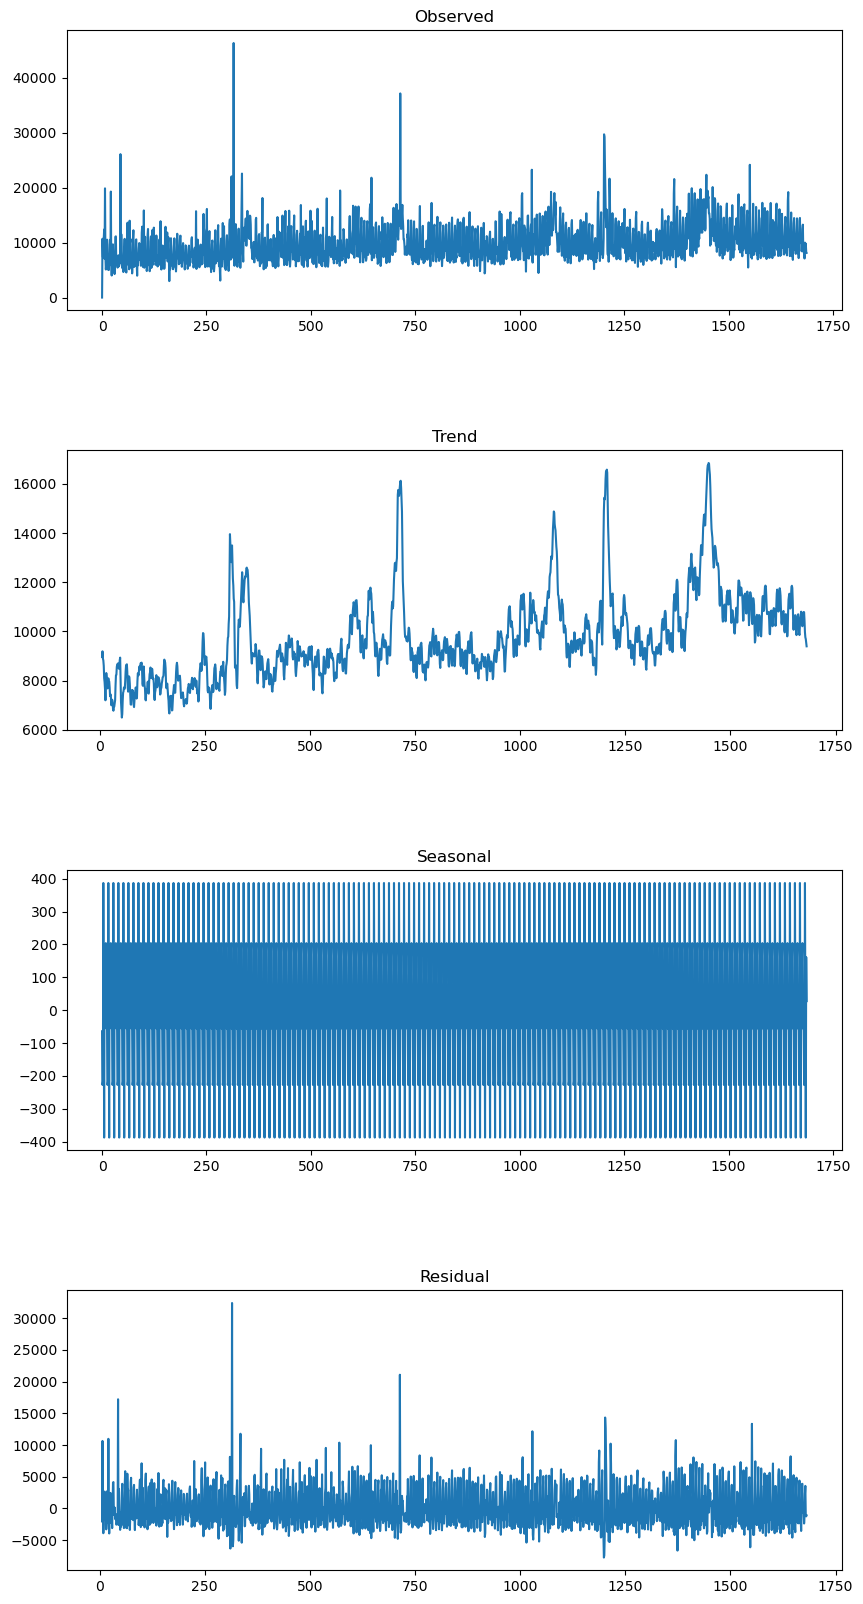

In [14]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# decompose the time series
decomposition = seasonal_decompose(data['sales'], model='additive', period=12)

# create a seasonal plot
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,20))
fig.subplots_adjust(hspace=0.5) # added space between subplots

decomposition.observed.plot(ax=axes[0], legend=False)
# axes[0].set_ylabel('Observed')
axes[0].set_title('Observed')

decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_title('Trend')

decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_title('Seasonal')

decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_title('Residual')

We can see an increasing trend and some seasonal pattern in the series and correlation between the present and past value. The mean of residual (noise) is around zero.

### 4.5.3 Identify Order of AR and MA Terms<a id='4.5.3'></a>

Using the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

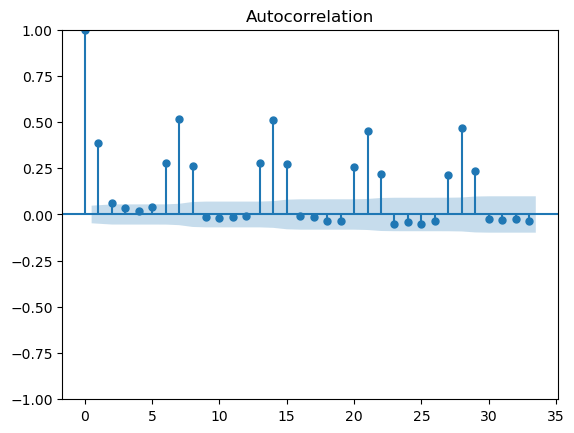

In [15]:
plot_acf(data['sales'], alpha = 0.05);

We have a correlation with 1, 6, 7, and 8 day sales in the past.

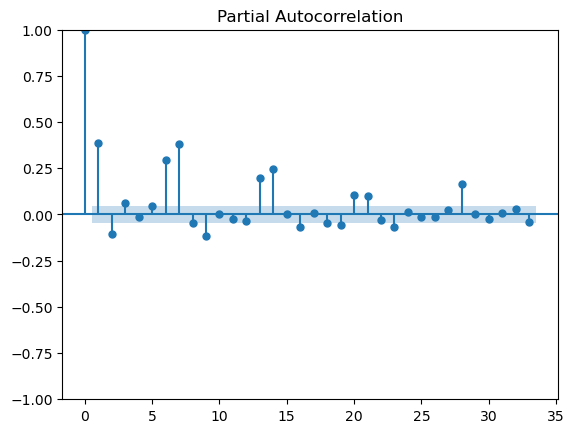

In [18]:
plot_pacf(data['sales'], alpha = 0.05, method='ywm');

We can choose 1, 6, and 7 days in the past.

## 4.6 Fit ARIMA Model<a id='4.6'></a>

In [36]:
import statsmodels.api as sm

# Define the order of differencing, AR, and MA terms
p = 1
d = 1
q = 1

train_np = data['sales'].values.astype('float64')
model = sm.tsa.ARIMA(train_np, order=(p, d, q))

model_fit = model.fit()

In [26]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

Model diagnostics:

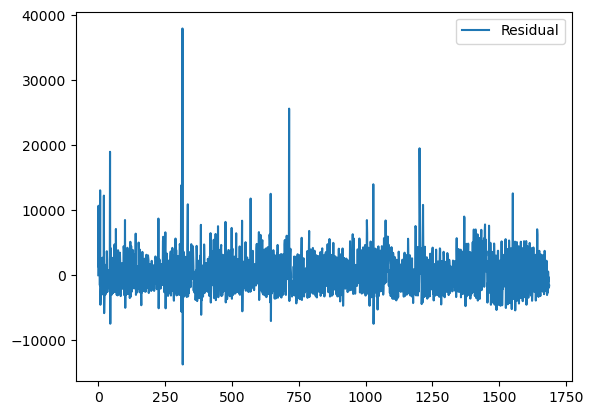

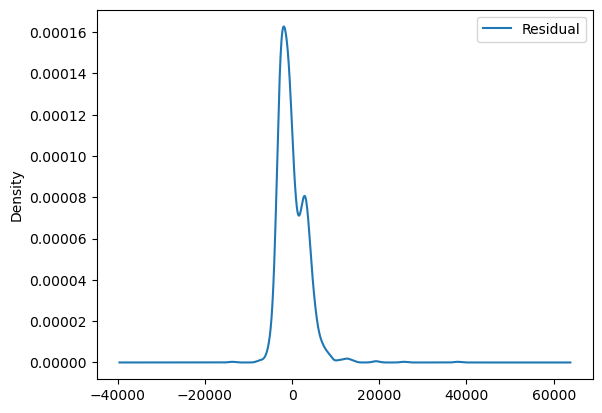

           Residual
count   1688.000000
mean      60.471207
std     3209.806554
min   -13739.489197
25%    -2230.279635
50%     -660.398093
75%     2207.492171
max    37966.411469


In [28]:
residuals = pd.DataFrame(model_fit.resid, columns=['Residual'])
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

Summary of the Model: 

In [25]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1688
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -16012.912
Date:                Thu, 04 May 2023   AIC                          32031.824
Time:                        08:59:06   BIC                          32048.117
Sample:                             0   HQIC                         32037.858
                               - 1688                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3091      0.016     19.565      0.000       0.278       0.340
ma.L1         -0.9753      0.006   -165.784      0.000      -0.987      -0.964
sigma2      1.027e+07   1.31e+05     78.324      0.0